![](https://theaisummer.com/static/3995761ad87f8909f5dec5925d182e80/4ff83/The-3D-Unet-model.png)

# **Image Segmentation with U-Net**

**Problem:**
Image segmentation is the process of partitioning an image into multiple meaningful regions, often to identify objects or boundaries. In medical imaging, autonomous driving, or satellite imagery, segmentation is critical for accurate analysis. This notebook focuses on semantic segmentation, where each pixel is classified into a specific category.

**Solution Approach:**
I use the U-Net architecture, a convolutional neural network specifically designed for image segmentation. U-Net consists of two main parts:

1. Encoder (Contracting Path):

* Extracts features from the input image using convolution and pooling layers.

* Captures contextual information and reduces spatial dimensions.

2. Decoder (Expanding Path):

* Reconstructs the segmented output to the original image size.

* Uses upsampling and concatenation with corresponding encoder features (skip connections) to preserve spatial details.

In [1]:
#The first problem is the size/shape of the images; we need to either crop or resize.
#dataset is so small and data augmentation may work in this case. But this method has already been done by another contributor and giving great results.


import os
import cv2
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import numpy as np


#reading images and resizing them into the same shape
root='../input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/'
imagearray=[]

for path,subs,files in os.walk(root):
    dirname=path.split(os.path.sep)[-1]
    if dirname=="images":
        images=os.listdir(path)
        for i,name in enumerate(images):
            if name.endswith(".jpg"):

                image=cv2.imread(path+"/"+name,1)
                image=cv2.resize(image,(256,256))
                image=np.array(image)
                imagearray.append(image)

maskarray=[]

for path,subs,files in os.walk(root):
    dirname=path.split(os.path.sep)[-1]
    if dirname=="masks":
        masks=os.listdir(path)
        for i,M_name in enumerate(masks):
            if M_name.endswith(".png"):

                mask =cv2.imread(path+"/"+M_name,1)
                mask =cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                mask =cv2.resize(mask,(256,256))
                mask =np.array(mask)
                maskarray.append(mask)

imagedata = np.array(imagearray)
maskdata =  np.array(maskarray)



In [2]:
# converting Hex to rgb. code:
# h = input('Enter hex: ').lstrip('#')
# print('RGB =', tuple(int(h[i:i+2], 16) for i in (0, 2, 4)))


# Building: 60, 16, 152
# Land  132, 41, 246,
#  road 110, 193, 228,
# Vegetation  254, 221, 58,
#  water 226, 169, 41,
#   155, 155, 155,

Building=np.array([60,16,152])
Land=np.array([132,41,246])
road=np.array([110,193,228])
Vegetation=np.array([254,221,58])
water=np.array([226,169,41])
Unlabeled =np.array([155,155,155])

label = maskdata

def flatLabels(label):

    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label == Building, axis=-1)] = 0
    label_seg[np.all(label == Land, axis=-1)] = 1
    label_seg[np.all(label == road, axis=-1)] = 2
    label_seg[np.all(label == Vegetation, axis=-1)] = 3
    label_seg[np.all(label == water, axis=-1)] = 4
    label_seg[np.all(label == Unlabeled, axis=-1)] = 5

    label_seg = label_seg[:, :, 0]  # Just take the first channel, no need for all 3 channels

    return label_seg

labels = []
for i in range(maskdata.shape[0]):
    label = flatLabels(maskdata[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [3]:
#one hot encoding to_categorical

n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

##for the proper way to importing segmentation models we need the import Keras also
!pip install segmentation-models==1.0.1
import keras
from keras.utils import generic_utils
import segmentation_models as sm


#splitting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imagedata, labels_cat, test_size = 0.20)

#those weights are optional, (automatically will be set all weights to 1)

weights = [0.155, 0.155, 0.155, 0.155, 0.155, 0.155]


#Creating a criterion to measure Dice loss class_weights – Array (np.array) of class weights (len(weights) = num_classes).
#for details check: https://github.com/qubvel/segmentation_models
dice_loss=sm.losses.DiceLoss(class_weights=weights)
focal=sm.losses.CategoricalFocalLoss()
total=dice_loss+(1*focal)

     |████████████████████████████████| 50 kB 3.9 MB/s 
Segmentation Models: using `keras` framework.


In [4]:
print("Total images:", imagedata.shape[0])
print("Image size:", imagedata.shape[1:])
print("Mask size:", labels.shape[1:])
print("Number of classes:", n_classes)

Total images: 72
Image size: (256, 256, 3)
Mask size: (256, 256, 1)
Number of classes: 6


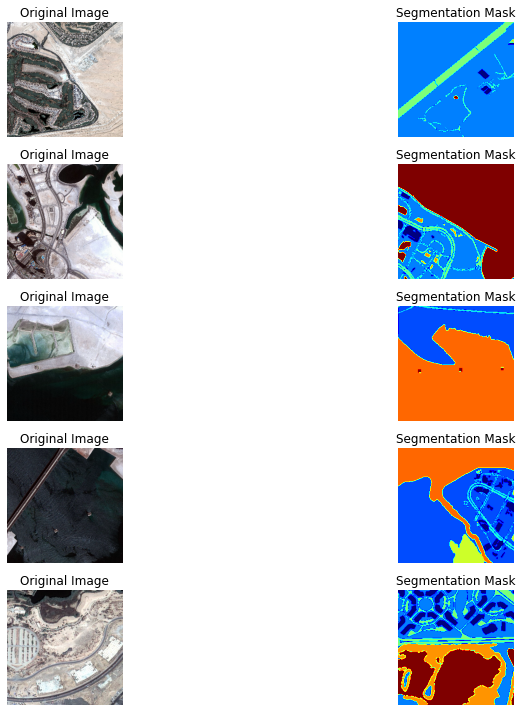

In [5]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(15,10))

for i in range(5):
    idx = random.randint(0, len(imagedata)-1)

    plt.subplot(5,2,2*i+1)
    plt.imshow(imagedata[idx])
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(5,2,2*i+2)
    plt.imshow(labels[idx].squeeze(), cmap='jet')
    plt.title("Segmentation Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

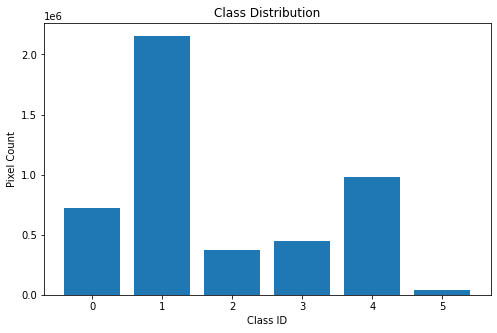

In [6]:
unique, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(8,5))
plt.bar(unique, counts)
plt.xlabel("Class ID")
plt.ylabel("Pixel Count")
plt.title("Class Distribution")
plt.show()


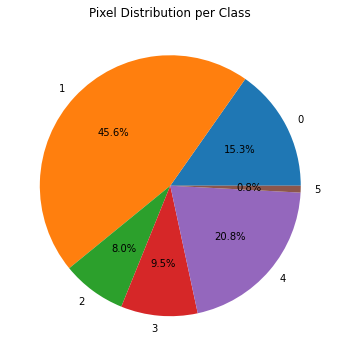

In [7]:
plt.figure(figsize=(6,6))
plt.pie(counts, labels=unique, autopct='%1.1f%%')
plt.title("Pixel Distribution per Class")
plt.show()


In [8]:
print(np.unique(y_train))
print(y_train.shape)

[0. 1.]
(57, 256, 256, 6)


# **U-Net Model 1**

In [9]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, \
    Dropout, Lambda
from keras import backend as K

# jacard_coef for loss:  https://github.com/ZFTurbo/ZF_UNET_224_Pretrained_Model/blob/master/zf_unet_224_model.py
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# architecture : https://github.com/zhixuhao/unet/blob/master/model.py
# https://github.com/bnsreenu/python_for_microscopists/blob/master/228_semantic_segmentation_of_aerial_imagery_using_unet/simple_multi_unet_model.py
def unet(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # define input layer
    s = inputs

    # begin with contraction part
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    # define output layer
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])


    return model


In [10]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]



metrics=['accuracy', jacard_coef]

def get_model():
    return unet(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total, metrics=metrics)
model.summary()


history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

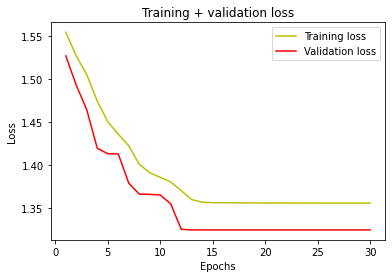

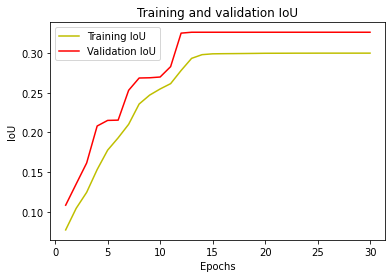

In [11]:
from matplotlib import pyplot as plt
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training + validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()



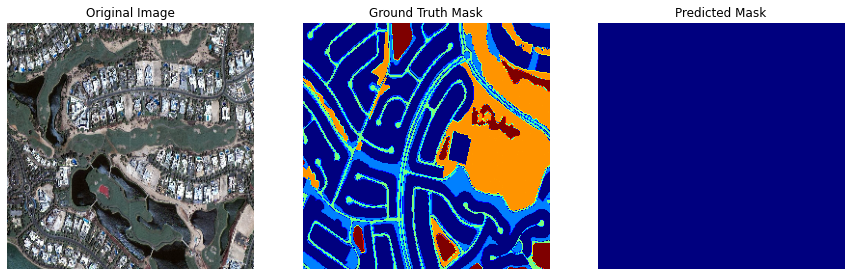

In [12]:
import matplotlib.pyplot as plt
import numpy as np

idx = np.random.randint(0, X_test.shape[0])

test_img = X_test[idx]
gt_mask = y_test[idx]

test_img_input = np.expand_dims(test_img, axis=0)

pred = model.predict(test_img_input)

pred_mask = np.argmax(pred, axis=-1)[0]
gt_mask = np.argmax(gt_mask, axis=-1)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(test_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(gt_mask, cmap='jet')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap='jet')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

# **U-Net Model 2**

In [13]:
y_train = y_train[:,:,:,0]
y_test = y_test[:,:,:,0]

y_train = np.expand_dims(y_train,-1)
y_test = np.expand_dims(y_test,-1)


In [14]:
print(y_train.shape)

(57, 256, 256, 1)


In [15]:
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.


In [16]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.)


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate

def unet(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    c1 = Conv2D(16,3,activation='relu',padding='same')(inputs)
    c1 = Conv2D(16,3,activation='relu',padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32,3,activation='relu',padding='same')(p1)
    c2 = Conv2D(32,3,activation='relu',padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(64,3,activation='relu',padding='same')(p2)
    c3 = Conv2D(64,3,activation='relu',padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    c4 = Conv2D(128,3,activation='relu',padding='same')(p3)
    c4 = Conv2D(128,3,activation='relu',padding='same')(c4)
    p4 = MaxPooling2D()(c4)

    c5 = Conv2D(256,3,activation='relu',padding='same')(p4)
    c5 = Conv2D(256,3,activation='relu',padding='same')(c5)

    u6 = Conv2DTranspose(128,2,strides=2,padding='same')(c5)
    u6 = concatenate([u6,c4])
    c6 = Conv2D(128,3,activation='relu',padding='same')(u6)
    c6 = Conv2D(128,3,activation='relu',padding='same')(c6)

    u7 = Conv2DTranspose(64,2,strides=2,padding='same')(c6)
    u7 = concatenate([u7,c3])
    c7 = Conv2D(64,3,activation='relu',padding='same')(u7)
    c7 = Conv2D(64,3,activation='relu',padding='same')(c7)

    u8 = Conv2DTranspose(32,2,strides=2,padding='same')(c7)
    u8 = concatenate([u8,c2])
    c8 = Conv2D(32,3,activation='relu',padding='same')(u8)
    c8 = Conv2D(32,3,activation='relu',padding='same')(c8)

    u9 = Conv2DTranspose(16,2,strides=2,padding='same')(c8)
    u9 = concatenate([u9,c1])
    c9 = Conv2D(16,3,activation='relu',padding='same')(u9)
    c9 = Conv2D(16,3,activation='relu',padding='same')(c9)

    outputs = Conv2D(1,(1,1),activation="sigmoid")(c9)
 
    return Model(inputs,outputs)


In [18]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3,factor=0.3),
    tf.keras.callbacks.EarlyStopping(patience=6,restore_best_weights=True)
]


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


model = unet()

model.compile(
 optimizer=tf.keras.optimizers.Adam(1e-4),
 loss="binary_crossentropy",
 metrics=[jacard_coef]
)



datagen = ImageDataGenerator(
 rotation_range=20,
 horizontal_flip=True,
 vertical_flip=True,
 zoom_range=0.2
)

train_gen = datagen.flow(X_train,y_train,batch_size=2)

history = model.fit(train_gen,
 steps_per_epoch=len(X_train)//2,
 epochs=80,
 validation_data=(X_test,y_test),
 batch_size=2

                   )



Epoch 1/80
28/28 [==============================] - 21s 700ms/step - loss: 0.6720 - jacard_coef: 0.1160 - val_loss: 0.6309 - val_jacard_coef: 0.1022
Epoch 2/80
28/28 [==============================] - 19s 692ms/step - loss: 0.5955 - jacard_coef: 0.1318 - val_loss: 0.4518 - val_jacard_coef: 0.0727
Epoch 3/80
28/28 [==============================] - 19s 685ms/step - loss: 0.4566 - jacard_coef: 0.0729 - val_loss: 0.4485 - val_jacard_coef: 0.0738
Epoch 4/80
28/28 [==============================] - 19s 688ms/step - loss: 0.4448 - jacard_coef: 0.0781 - val_loss: 0.4476 - val_jacard_coef: 0.0750
Epoch 5/80
28/28 [==============================] - 19s 685ms/step - loss: 0.5258 - jacard_coef: 0.1079 - val_loss: 0.4411 - val_jacard_coef: 0.0499
Epoch 6/80
28/28 [==============================] - 19s 687ms/step - loss: 0.4896 - jacard_coef: 0.0819 - val_loss: 0.4270 - val_jacard_coef: 0.0656
Epoch 7/80
28/28 [==============================] - 19s 689ms/step - loss: 0.4590 - jacard_coef: 0.0716 - 

In [20]:
from tensorflow.keras.metrics import MeanIoU

pred = model.predict(X_test)
pred = np.argmax(pred,axis=-1)
gt = np.argmax(y_test,axis=-1)

miou = MeanIoU(num_classes=n_classes)
miou.update_state(gt,pred)
print("Mean IoU:",miou.result().numpy())


Mean IoU: 1.0


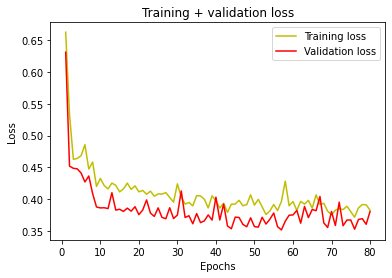

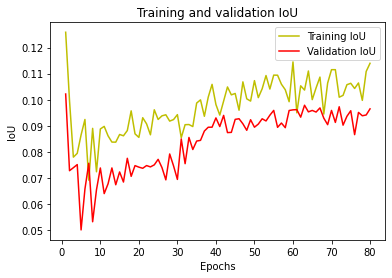

In [21]:
from matplotlib import pyplot as plt
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training + validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

# I would like to thank Dr. Sreenivas Bhattiprolu for giving me so much inspiration for this analysis, I tried to apply what I learned from his channel to this notebook. check his wonderful youtube channel:  https://www.youtube.com/channel/UC34rW-HtPJulxr5wp2Xa04w

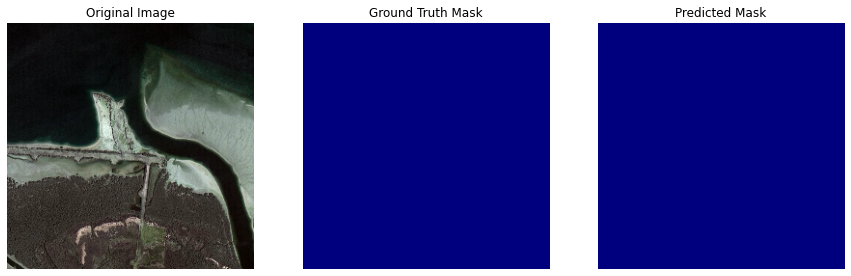

In [22]:
import matplotlib.pyplot as plt
import numpy as np

idx = np.random.randint(0, X_test.shape[0])

test_img = X_test[idx]
gt_mask = y_test[idx]

test_img_input = np.expand_dims(test_img, axis=0)

pred = model.predict(test_img_input)

pred_mask = np.argmax(pred, axis=-1)[0]
gt_mask = np.argmax(gt_mask, axis=-1)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(test_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(gt_mask, cmap='jet')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap='jet')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()